### Import Libraries

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import zscore
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_samples, silhouette_score
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import StandardScaler

### Load the data

In [37]:
df = pd.read_csv('auto-mpg.csv')
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB


In [39]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
mpg,398.0,23.514573,7.815984,9.0,17.500,23.0,29.000,46.6
cylinders,398.0,5.454774,1.701004,3.0,4.000,4.0,8.000,8.0
displacement,398.0,193.425879,104.269838,68.0,104.250,148.5,262.000,455.0
weight,398.0,2970.424623,846.841774,1613.0,2223.750,2803.5,3608.000,5140.0
acceleration,398.0,15.568090,2.757689,8.0,13.825,15.5,17.175,24.8
model year,398.0,76.010050,3.697627,70.0,73.000,76.0,79.000,82.0
origin,398.0,1.572864,0.802055,1.0,1.000,1.0,2.000,3.0


In [40]:
df.shape

(398, 9)

In [41]:
# checking nulls in columns

df.isnull().sum()

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64

In [42]:
df['horsepower'].unique()

array(['130', '165', '150', '140', '198', '220', '215', '225', '190',
       '170', '160', '95', '97', '85', '88', '46', '87', '90', '113',
       '200', '210', '193', '?', '100', '105', '175', '153', '180', '110',
       '72', '86', '70', '76', '65', '69', '60', '80', '54', '208', '155',
       '112', '92', '145', '137', '158', '167', '94', '107', '230', '49',
       '75', '91', '122', '67', '83', '78', '52', '61', '93', '148',
       '129', '96', '71', '98', '115', '53', '81', '79', '120', '152',
       '102', '108', '68', '58', '149', '89', '63', '48', '66', '139',
       '103', '125', '133', '138', '135', '142', '77', '62', '132', '84',
       '64', '74', '116', '82'], dtype=object)

In [43]:
#Convert horsepower from categorical to numeric
#Also remove the "?"
df['horsepower'] = df['horsepower'].replace('?', np.nan)
df['horsepower'] = df['horsepower'].apply(lambda x: float(x))

In [44]:
#Lets drop the car names as we do not need it for the purpose of our analysis
df.drop('car name', axis = 1, inplace=True)

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
dtypes: float64(4), int64(4)
memory usage: 25.0 KB


In [46]:
#The origin column should be categorical for the EDA.
df_eda = df.copy()
df_eda['origin'] = df_eda['origin'].replace({1: 'america', 2: 'europe', 3: 'asia'})

In [47]:
df_eda.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,18.0,8,307.0,130.0,3504,12.0,70,america
1,15.0,8,350.0,165.0,3693,11.5,70,america
2,18.0,8,318.0,150.0,3436,11.0,70,america
3,16.0,8,304.0,150.0,3433,12.0,70,america
4,17.0,8,302.0,140.0,3449,10.5,70,america


In [48]:
#Lets check the percentage of null values 
df.isnull().mean().sort_values(ascending=False) * 100


horsepower      1.507538
mpg             0.000000
cylinders       0.000000
displacement    0.000000
weight          0.000000
acceleration    0.000000
model year      0.000000
origin          0.000000
dtype: float64

In [49]:
#Impute the missing horsepower values with median
df['horsepower'].fillna(df['horsepower'].median(), inplace=True)
#Do the same for df_eda
df_eda['horsepower'].fillna(df_eda['horsepower'].median(), inplace=True)


In [50]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    float64
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    object 
dtypes: float64(4), int64(3), object(1)
memory usage: 25.0+ KB


In [51]:
#The number of cylinders and model year are also categorical variables. Lets convert them appropriately.
# df_eda['cylinders'] = df_eda['cylinders'].apply(lambda x: str(x))
# df_eda['model year'] = df_eda['model year'].apply(lambda x: str(x))


In [52]:
#split the categorical and numeric variables
numeric = ['mpg', 'displacement', 'horsepower', 'weight', 'acceleration']
categorical = ['cylinders', 'model year', 'origin']

#### Univariate Analysis

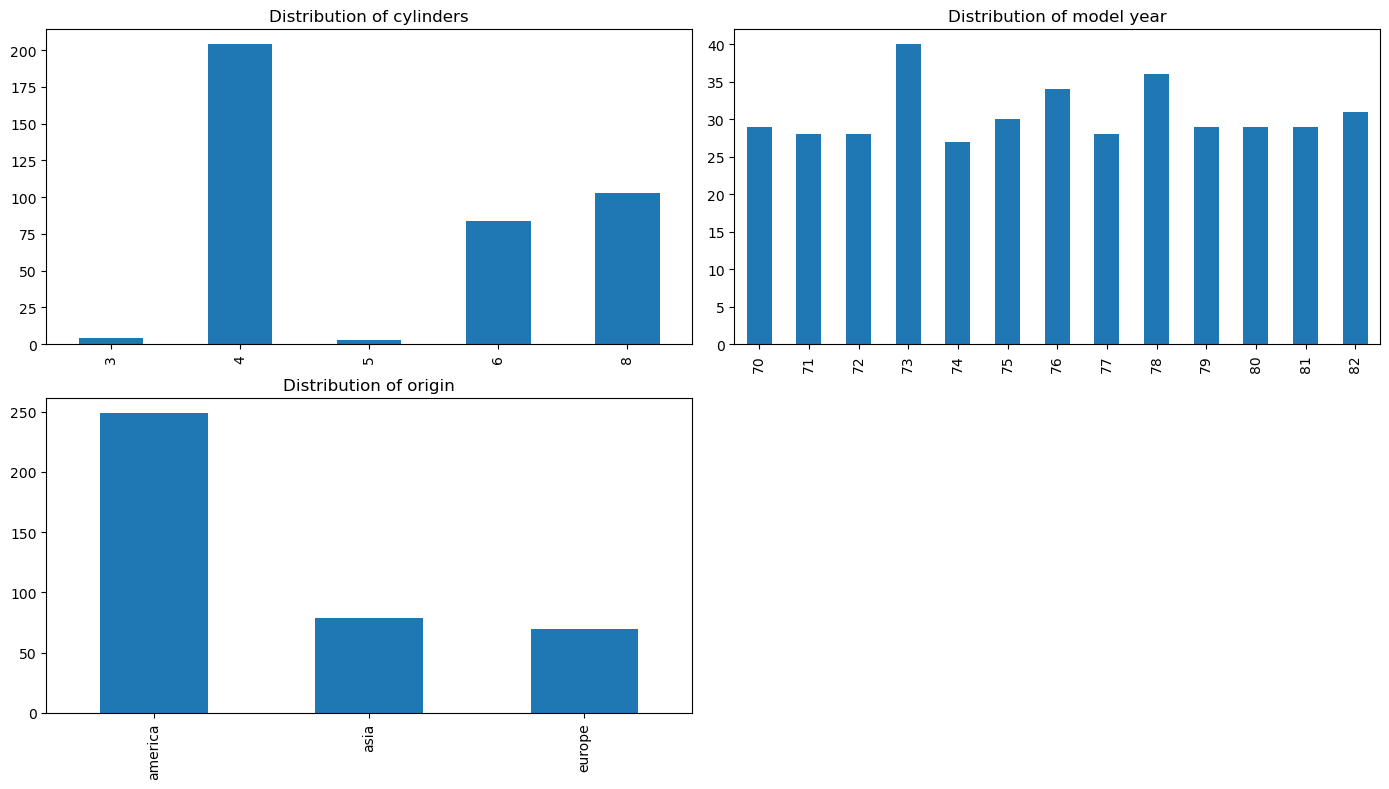

In [53]:
#plotting categorical variables
fig = plt.figure(1, (14, 8))

for i,car in enumerate(df_eda[categorical].columns):
    ax = plt.subplot(2,2,i+1)
    df_eda[car].value_counts().sort_index().plot.bar()
    ax.set_xlabel(None)
    ax.set_title(f'Distribution of {car}')
    plt.tight_layout()

plt.show()

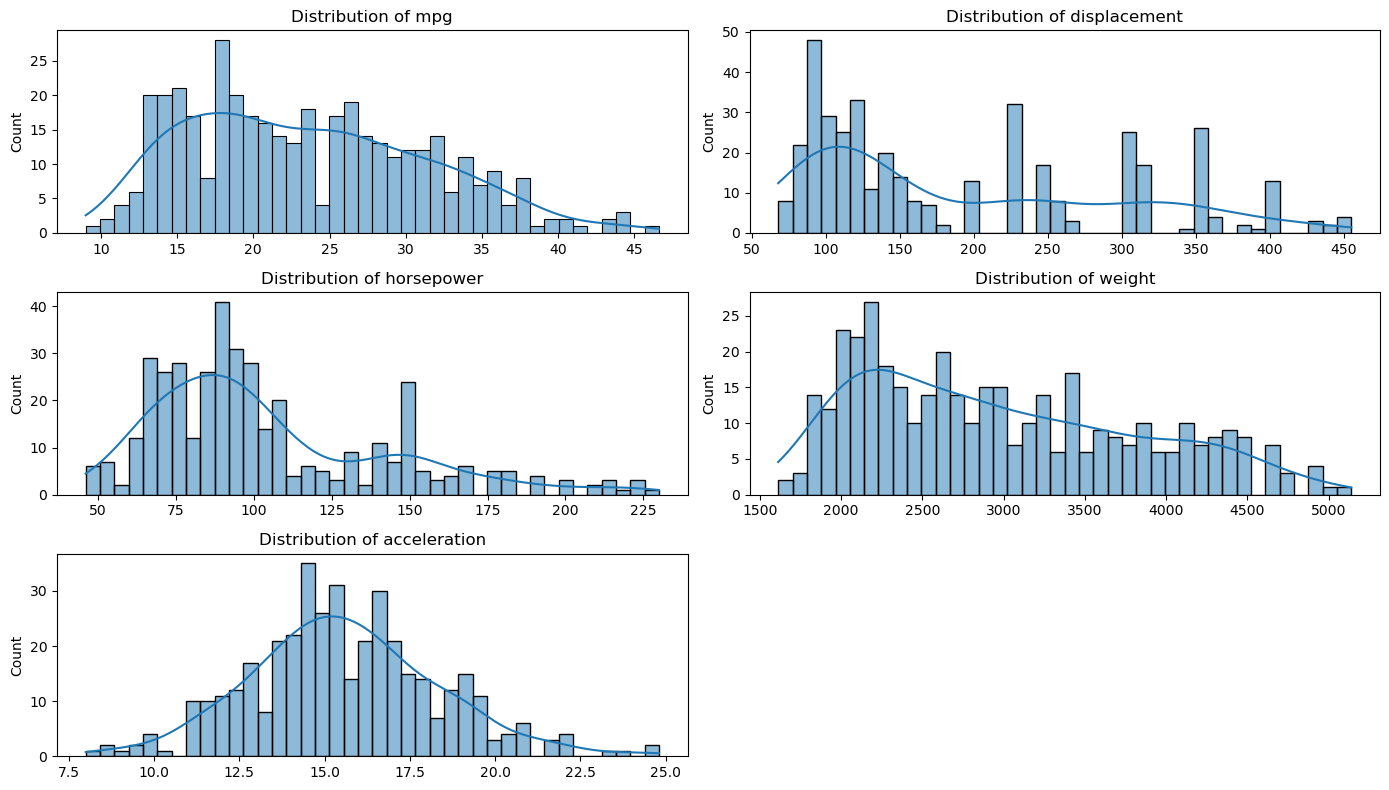

In [54]:
#plotting numeric variables
fig = plt.figure(1, (14, 8))

for i,car in enumerate(df_eda[numeric].columns):
    ax = plt.subplot(3,2,i+1)
    #df_eda[car].plot.hist(bins=30)
    sns.histplot(df_eda[car], kde=True, bins=40)
    ax.set_xlabel(None)
    ax.set_title(f'Distribution of {car}')
    plt.tight_layout()

plt.show()

### Bivariate analysis

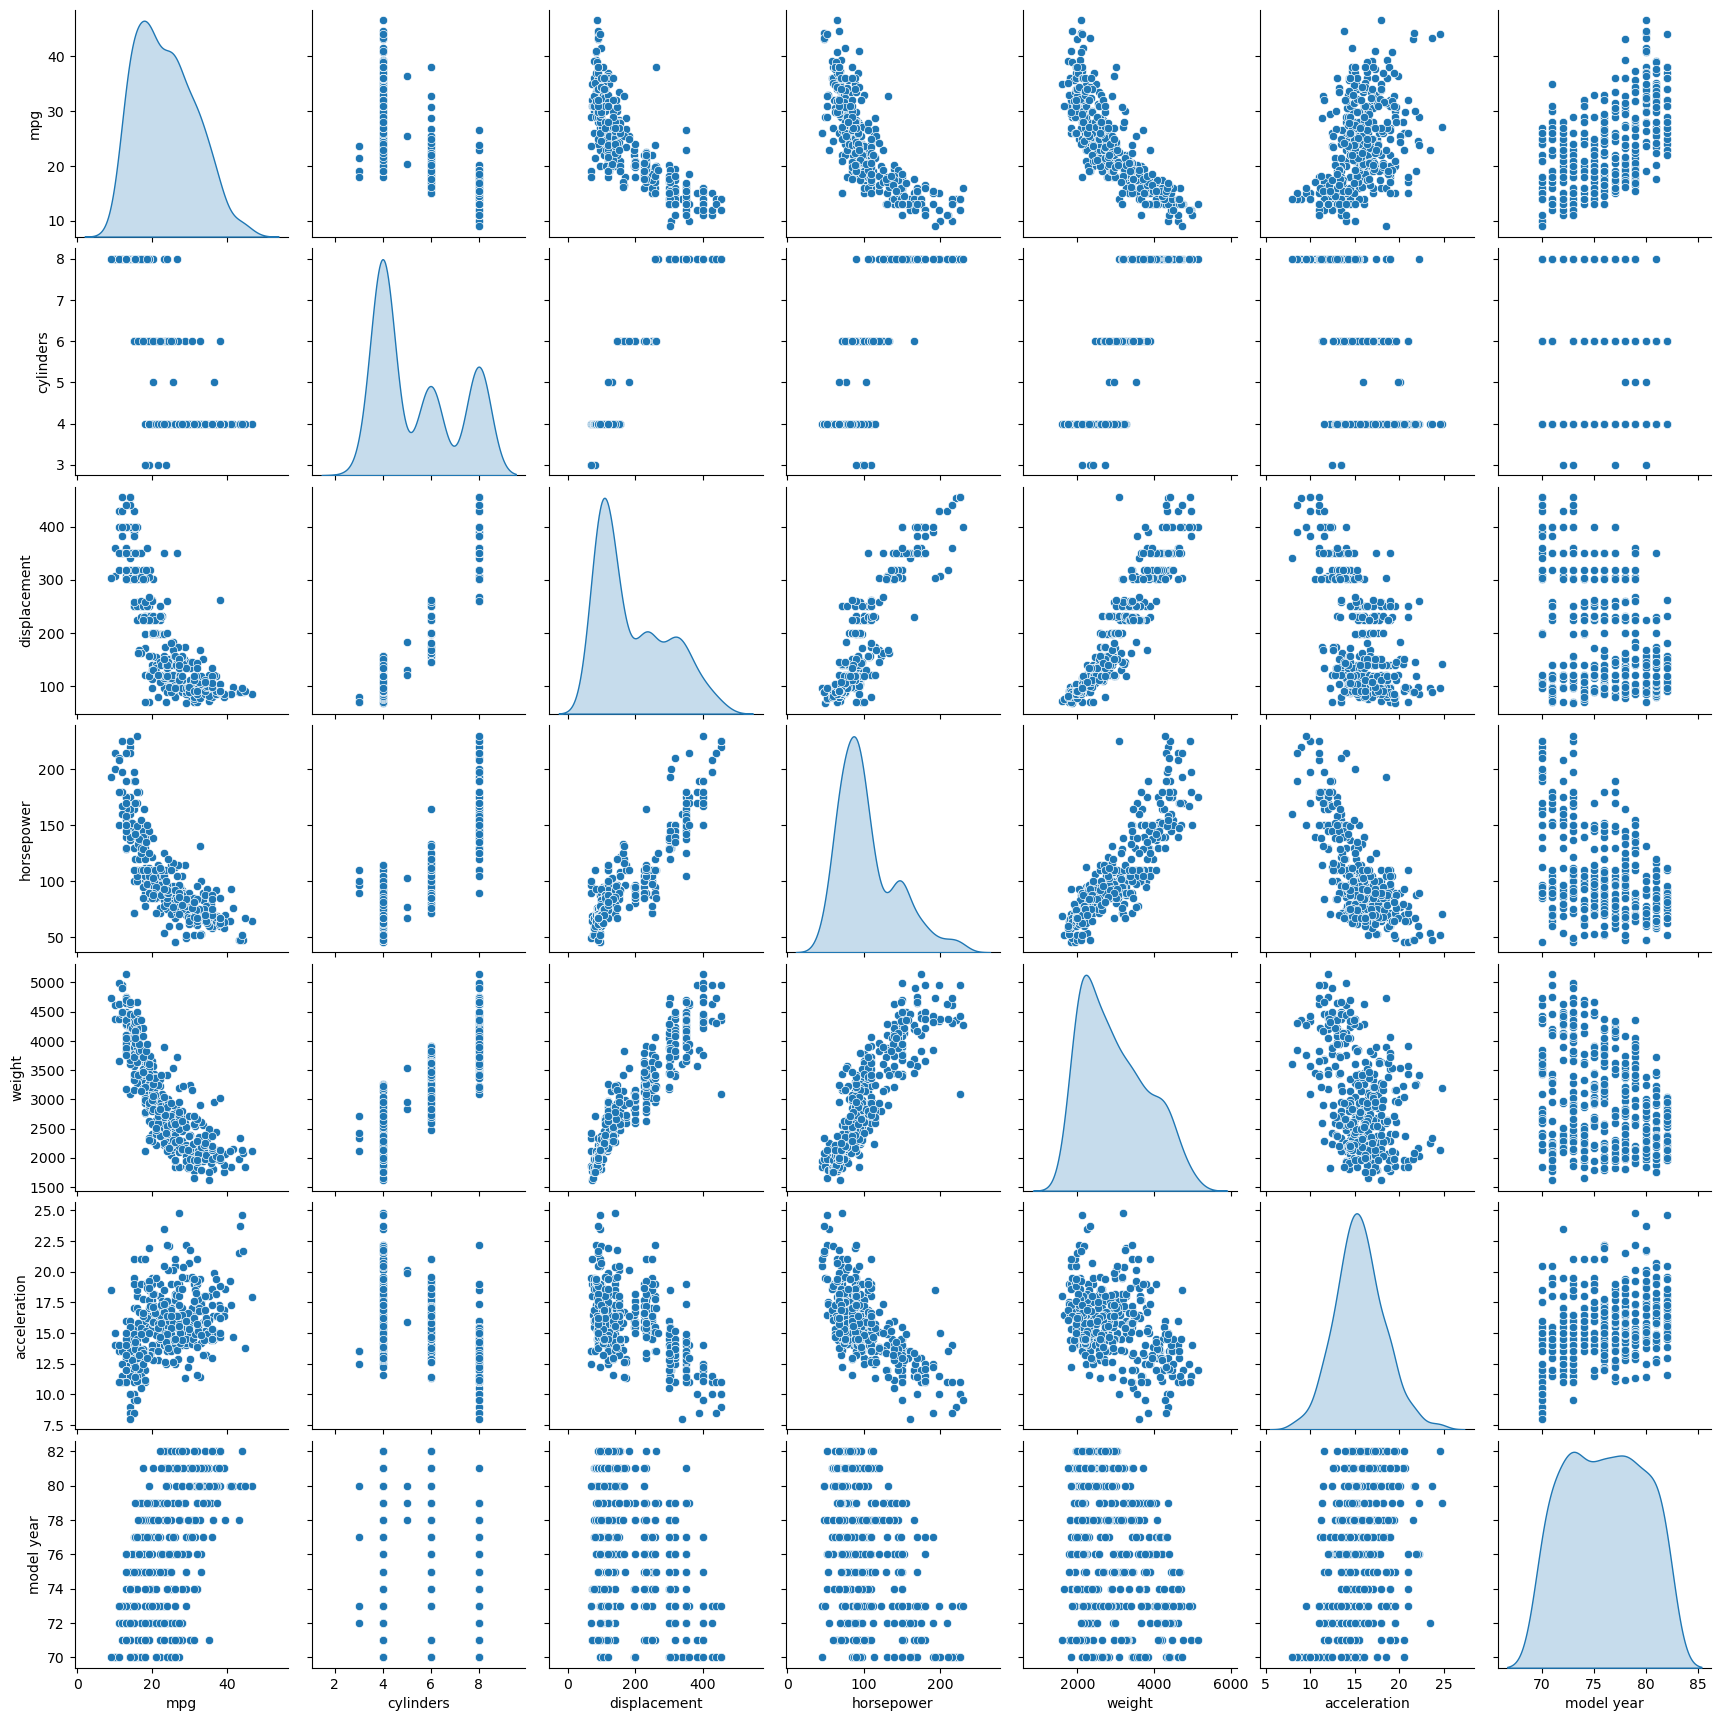

In [55]:
#check the correlation between all the variables
sns.pairplot(df_eda, diag_kind='kde');

- We see that weight, horsepower and displacement are inversely proportional to mpg. 
- Horsepower and displacement are directly proportional to weight
- Horsepower and displacement are directly proportional to each other

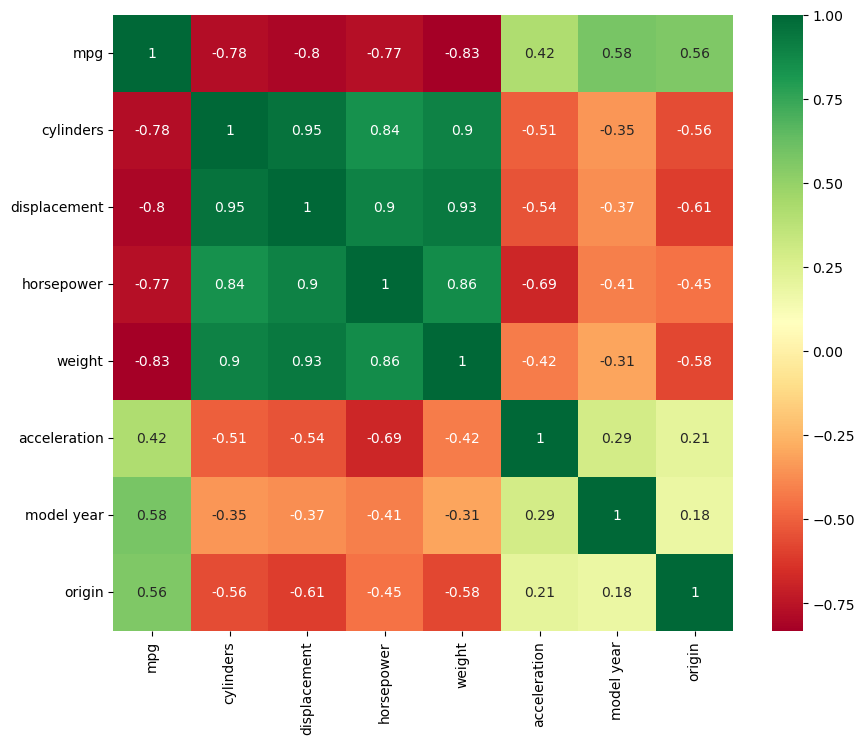

In [56]:
#checking for correlation
plt.figure(figsize=(10,8))
corr=df.corr()
sns.heatmap(corr,cmap = 'RdYlGn',annot=True);


## K-Means Clustering

In [57]:
#standardized feature scaling
df_scaled=df.apply(zscore)
df_scaled.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,-0.706439,1.498191,1.090604,0.673118,0.630870,-1.295498,-1.627426,-0.715145
1,-1.090751,1.498191,1.503514,1.589958,0.854333,-1.477038,-1.627426,-0.715145
2,-0.706439,1.498191,1.196232,1.197027,0.550470,-1.658577,-1.627426,-0.715145
3,-0.962647,1.498191,1.061796,1.197027,0.546923,-1.295498,-1.627426,-0.715145
4,-0.834543,1.498191,1.042591,0.935072,0.565841,-1.840117,-1.627426,-0.715145


In [58]:
#calculating the within sum of squares
wss =[] 
for i in range(1,5):
    KM = KMeans(n_clusters=i)
    KM.fit(df_scaled)
    wss.append(KM.inertia_)

In [59]:
wss

[3184.0, 1588.592456791863, 1190.0436525504851, 987.9431670099705]

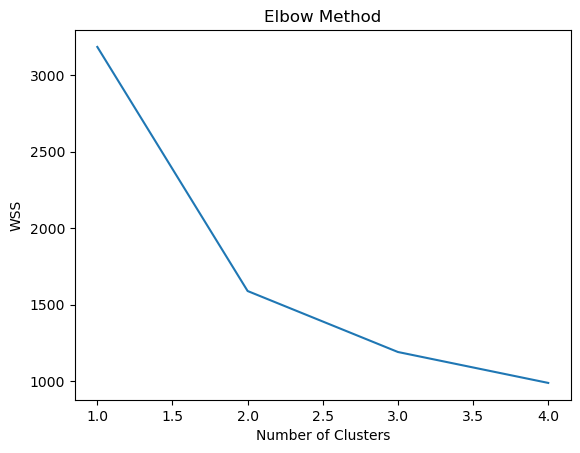

In [60]:
#plotting the WSS against the number of cluster to come up with optimal number of clusters(K) using Elbow-method
plt.plot(range(1,5), wss);
plt.title('Elbow Method');
plt.xlabel("Number of Clusters")
plt.ylabel("WSS");

In [61]:
#using 2 centroids for clustering
k_means = KMeans(n_clusters = 2)
k_means.fit(df_scaled)
labels = k_means.labels_

In [62]:
# Calculating silhouette_score
silhouette_score(df_scaled,labels)

0.4148919831294719

In [63]:
#calculating silhouette score for different centroids
kmeans_kwargs = {
   "init": "random",
   "n_init": 10,
   "max_iter": 300,
   "random_state": 42,
}
silhouette_coefficients = []

#Start at 2 clusters for silhouette coefficient
for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df_scaled)
    score = silhouette_score(df_scaled,kmeans.labels_)
    silhouette_coefficients.append(score)

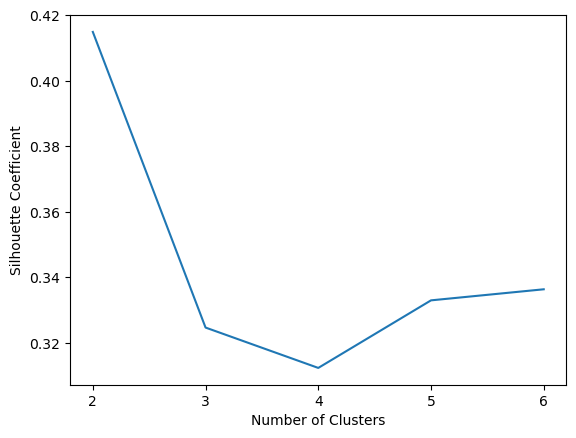

In [64]:
#plotting silhouette score for different centroids
plt.plot(range(2, 7), silhouette_coefficients)
plt.xticks(range(2, 7))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [65]:
#attaching the labels to the datasets
df["cluster_K"] = labels
Kclus=df
Kclus.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,cluster_K
0,18.0,8,307.0,130.0,3504,12.0,70,1,1
1,15.0,8,350.0,165.0,3693,11.5,70,1,1
2,18.0,8,318.0,150.0,3436,11.0,70,1,1
3,16.0,8,304.0,150.0,3433,12.0,70,1,1
4,17.0,8,302.0,140.0,3449,10.5,70,1,1


In [31]:
#vieweing the distribution of clusters
Kclus.cluster_K.value_counts().sort_index()

0    169
1    229
Name: cluster_K, dtype: int64

In [32]:
#attaching the clusters to the scaled data
df_scaled["cluster_K"] = labels
df_scaled.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,cluster_K
0,-0.706439,1.498191,1.090604,0.673118,0.630870,-1.295498,-1.627426,-0.715145,0
1,-1.090751,1.498191,1.503514,1.589958,0.854333,-1.477038,-1.627426,-0.715145,0
2,-0.706439,1.498191,1.196232,1.197027,0.550470,-1.658577,-1.627426,-0.715145,0
3,-0.962647,1.498191,1.061796,1.197027,0.546923,-1.295498,-1.627426,-0.715145,0
4,-0.834543,1.498191,1.042591,0.935072,0.565841,-1.840117,-1.627426,-0.715145,0


In [33]:
#aggregating the numerical variable with the clusters formed with the mean
aggdata=Kclus.groupby("cluster_K").mean()
aggdata['Freq']=Kclus.cluster_K.value_counts().sort_index()
aggdata

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,Freq
cluster_K,,,,,,,,,
0,16.440237,7.218935,299.485207,136.085799,3785.698225,14.353846,74.366864,1.017751,169
1,28.735371,4.152838,115.155022,80.849345,2368.759825,16.464192,77.222707,1.982533,229


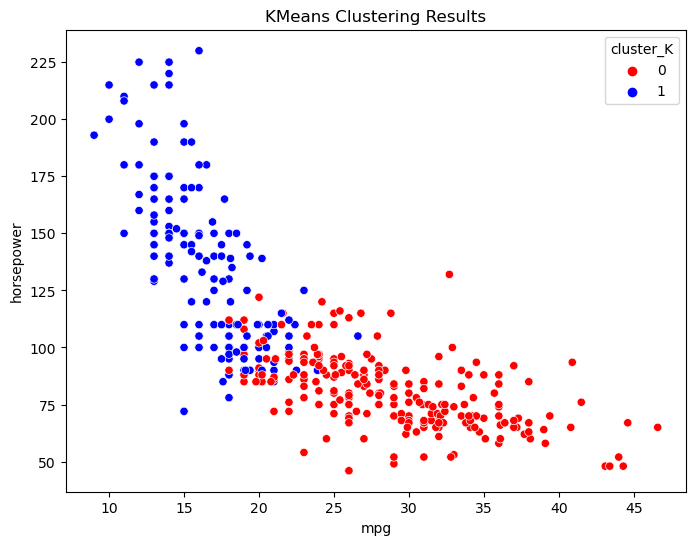

In [74]:
#plotting the clusters
plt.figure(figsize=(8, 6))
plt.title('KMeans Clustering Results')
sns.scatterplot(x="mpg", y="horsepower", hue="cluster_K",
              data=Kclus, 
                    palette=['red','blue']);

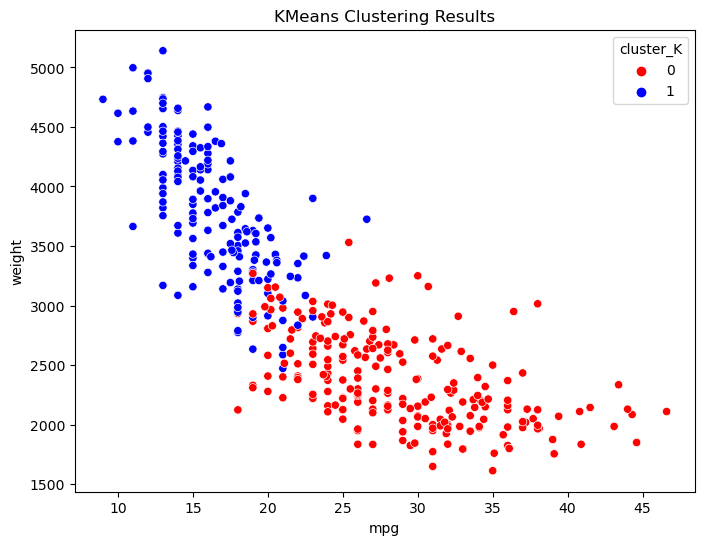

In [73]:
#plotting the clusters
plt.figure(figsize=(8, 6))
plt.title('KMeans Clustering Results')
sns.scatterplot(x="mpg", y="weight", hue="cluster_K",
              data=Kclus, 
                    palette=['red','blue']);

In [67]:
# Drop any non-numeric columns
numeric_df = df.drop('origin', axis=1)

In [68]:
# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_df)

In [69]:
# Compute pairwise distances
distance_matrix = pairwise_distances(scaled_data, metric='euclidean')

# Convert distance matrix to affinity matrix
affinity_matrix = np.exp(-distance_matrix ** 2 / (2. * np.std(distance_matrix) ** 2))

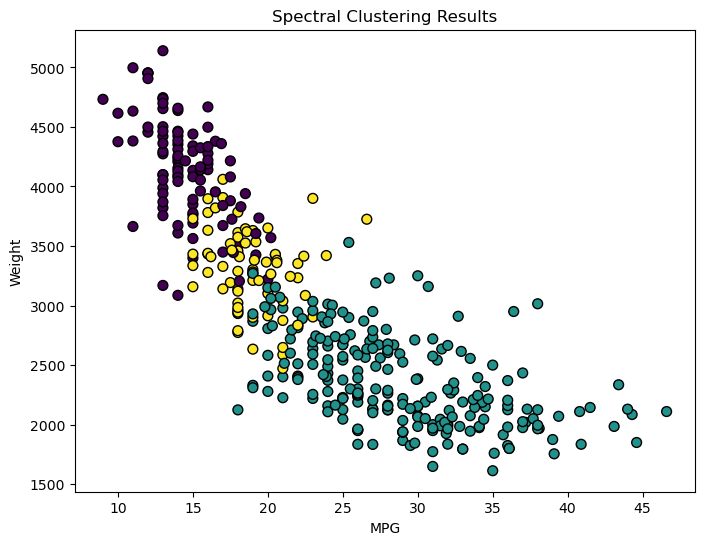

In [70]:
# Perform spectral clustering
n_clusters = 3  # Set the number of clusters
spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
df['cluster_label'] = spectral.fit_predict(affinity_matrix)

# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(df['mpg'], df['weight'], c=df['cluster_label'], cmap='viridis', edgecolor='k', s=50)
plt.title('Spectral Clustering Results')
plt.xlabel('MPG')
plt.ylabel('Weight')
plt.show()

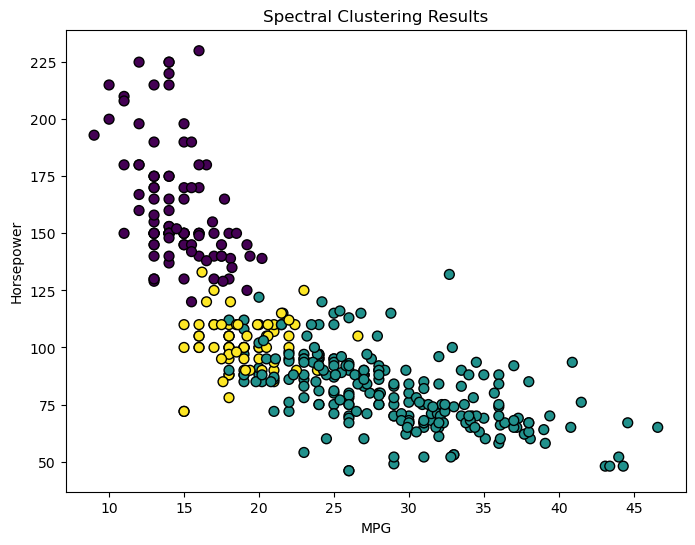

In [71]:
# Plot the clusters for 'mpg' versus 'horsepower'
plt.figure(figsize=(8, 6))
plt.scatter(df['mpg'], df['horsepower'], c=df['cluster_label'], cmap='viridis', edgecolor='k', s=50)
plt.title('Spectral Clustering Results')
plt.xlabel('MPG')
plt.ylabel('Horsepower')
plt.show()